In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

## Generating / plotting the plant filter

83


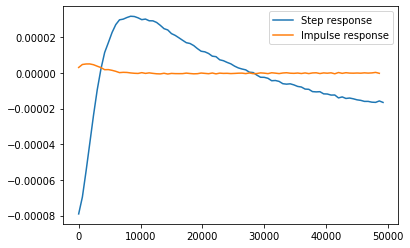

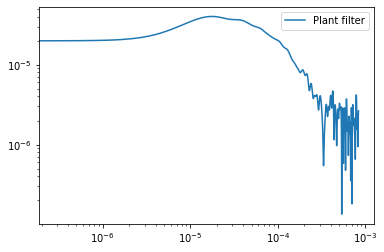

4.993706070287539e-06


In [3]:
ITMYRH_data = np.loadtxt('../data/ITMY_trend_10min_int_longer.dat')
t = np.arange(0,len(ITMYRH_data[:,0][2:]))*60.0*10.0
normalize = 3.13
print(len(t))
data_in = ITMYRH_data[:,1][2:]
b, a = signal.butter(2, .2)
#data_new = signal.filtfilt(b,a,data_in)
data_new = data_in
plt.figure()
ir = (data_new[1:] - data_new[:-1])/normalize
ir_new = ir
plt.plot(t, data_new, label='Step response')
plt.plot(t[:(len(t)-1)], ir, label= 'Impulse response')
plt.legend()
plt.show()

Fs = 1/(t[2]-t[1])
#print(Fs)

[F,H]=signal.freqz(ir_new,1, worN=3000,whole=False) 
plt.figure()
plt.loglog(F*Fs/(2*np.pi), abs(H), label='Plant filter')
plt.legend()
plt.show()


#results = IIRrational.v2.data2filter(
#    data = abs(H),
#    F_Hz = F,
#)
print(max(ir_new))

## Plotting plant filter with fitted filter

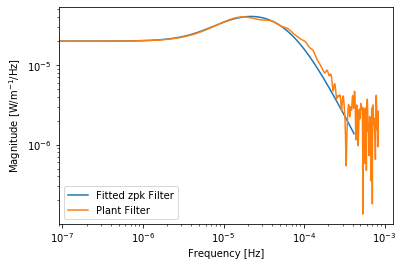

9.729529652779821e-12


In [4]:
#model =  zpk(-2*pi*5e-6, -2.*pi.*[1.3e-5; 9.5e-5; 5e-5],1);

zeros = 5.0e-6
fit_zeros = -2.0*np.pi*5.0e-6
poles = np.array([1.3e-5, 5.0e-5 ,9.5e-5])
fit_poles = -2.0*np.pi*poles

k = 1 #This gain is not initally correct

s1 = signal.ZerosPolesGain(fit_zeros, fit_poles, k)
F_2, H_2 = signal.freqresp(s1, F*(Fs/2.0))

#[F_2,H_2] = signal.freqs(b_2, a_2)
k_new = abs(H[0])/abs(H_2[0])

plt.loglog(F_2/(2*np.pi), abs(H_2)*k_new, label='Fitted zpk Filter')
plt.loglog(F/(2*np.pi)*Fs, abs(H), label='Plant Filter')
plt.ylabel('Magnitude [W/m$^{-1}$/Hz]')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.show()

print(k_new) #Spit out the new gain

model_zpk = signal.ZerosPolesGain(fit_zeros, fit_poles,k_new)

## Double check that the simulated step response closely follows the plant

In [5]:
unit_step = np.zeros((t.shape[0]*25))
t_new = np.arange(0,len(unit_step))*60.0*1.0
## Generating simulated response
unit_step[t_new>36000] = 1
[t_mod_new,y_mod_sim,xout] = signal.lsim(model_zpk, unit_step, t_new)

In [37]:
## Some plotting defaults
lin_thickness = 4

title_font = {'fontname':'Arial', 'size':'35', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'25'}



Text(0.5, 0, 'time [hr]')

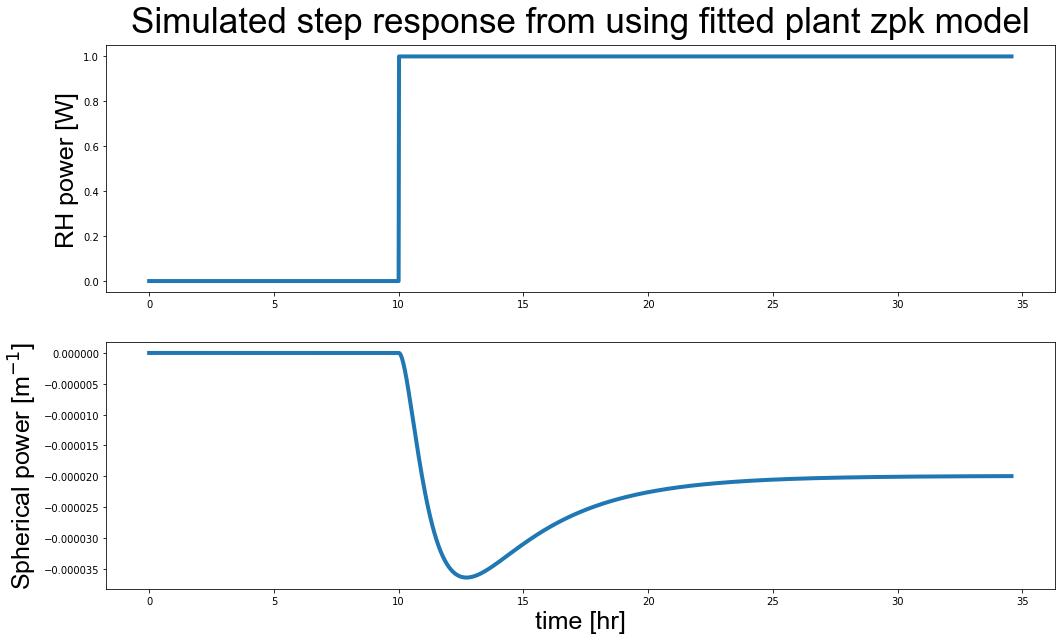

In [38]:
fig = plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(t_new/3600, unit_step,linewidth = lin_thickness)
plt.ylabel('RH power [W]',**axis_font)
plt.title('Simulated step response from using fitted plant zpk model',**title_font)
plt.subplot(212)
plt.plot(t_new/3600,-y_mod_sim, linewidth = lin_thickness)
plt.ylabel('Spherical power [m$^{-1}$]',**axis_font)
plt.xlabel('time [hr]',**axis_font)


Text(0.5, 0, 'Frequency [Hz]')

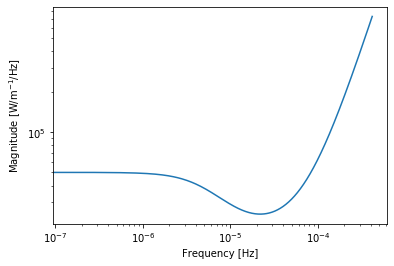

In [39]:
## Now to invert the plant filter (just swapping the poles and the zeros and inverting gain)
inv_model = signal.ZerosPolesGain(fit_poles, fit_zeros,1/k_new)
F_3, H_3 = signal.freqresp(inv_model, F*(Fs/2.0))
plt.loglog(F_3/(2*np.pi), abs(H_3), label='Fitted zpk Filter')
plt.ylabel('Magnitude [W/m$^{-1}$/Hz]')
plt.xlabel('Frequency [Hz]')

Text(0.5, 0, 'Frequency [Hz]')

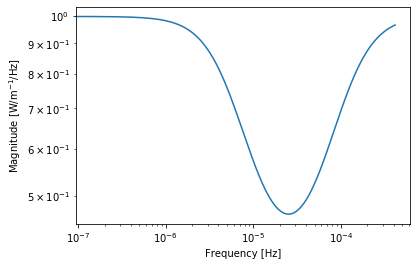

In [40]:
rh_input_filter = signal.ZerosPolesGain(fit_poles, [fit_zeros,-2.0*np.pi*.0001113129672, -2.0*np.pi*.0001113129672],1)
F_4, H_4 = signal.freqresp(rh_input_filter,F*(Fs/2.0))
plt.loglog(F_4/(2*np.pi), abs(H_4), label='Fitted zpk Filter')
plt.ylabel('Magnitude [W/m$^{-1}$/Hz]')
plt.xlabel('Frequency [Hz]')

## Testing the new filter

In [41]:
[ _ ,y_inp_inv, _] = signal.lsim(rh_input_filter, unit_step, t_new)
[ _ ,y_mod_sim_inv, _] = signal.lsim(model_zpk, y_inp_inv, t_new)

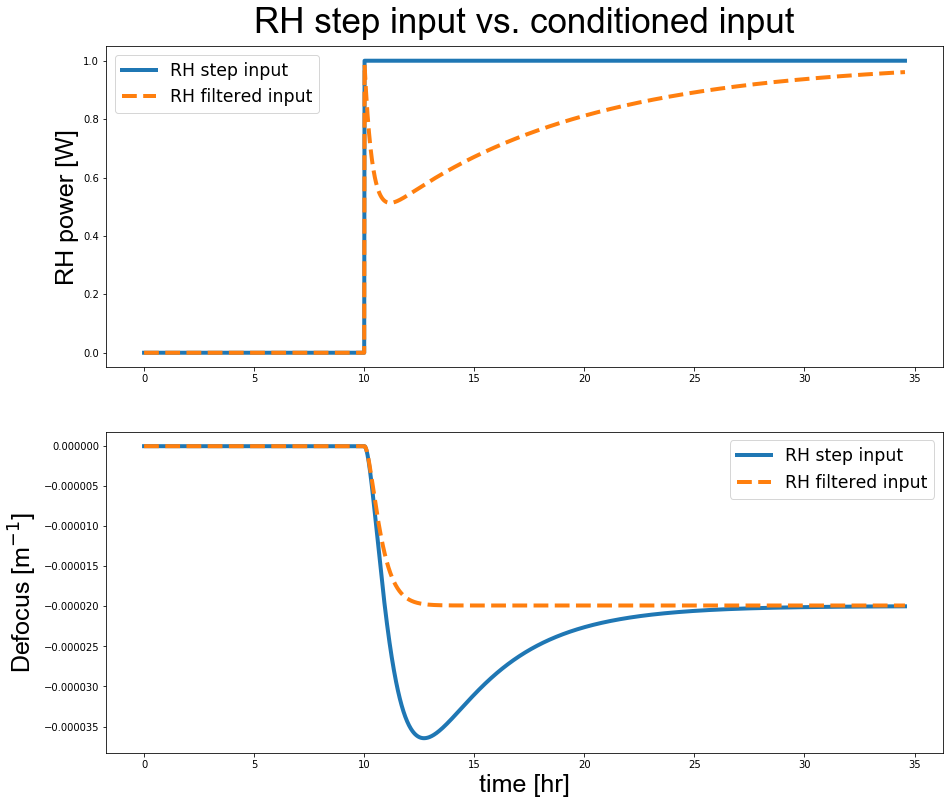

In [49]:
fig = plt.figure(figsize=(15,13))
plt.subplot(211)
plt.plot(t_new/3600, unit_step,linewidth = lin_thickness,label='RH step input')
plt.plot(t_new/3600, y_inp_inv,'--', linewidth = lin_thickness,label='RH filtered input')
plt.ylabel('RH power [W]',**axis_font)
plt.title('RH step input vs. conditioned input',**title_font)
plt.legend(fontsize = 'xx-large')
plt.subplot(212)
plt.plot(t_new/3600,-y_mod_sim, linewidth = lin_thickness,label='RH step input')
plt.plot(t_new/3600,-y_mod_sim_inv,'--', linewidth = lin_thickness,label='RH filtered input')
plt.ylabel('Defocus [m$^{-1}$]',**axis_font)
plt.xlabel('time [hr]',**axis_font)
plt.legend(fontsize = 'xx-large')

fig.savefig('IRHF.pdf')